<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/Copy_of_bsplinetrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,random,vmap
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib.pyplot as plt

In [3]:
class SimpleMLP(nn.Module):
    features:Sequence[int]
    nodes:int

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            x=jnp.sin(x)
        t=nn.Dense(nodes-1)(x)
        c=nn.Dense(nodes+1)(x)
        t=jnp.concatenate([jnp.zeros((t.shape[0],4)),jnp.cumsum(jax.nn.softmax(t),axis=1),jnp.ones((t.shape[0],3))],axis=1)
        c=jnp.concatenate([jnp.zeros((c.shape[0],1)),c],axis=1)
        return t,c

In [4]:
def npy_loader(path):
    return jnp.load(path)

In [5]:
@jit
def _deBoorVectorized(x,t,c):
    p=3
    k=jnp.digitize(x,t)-1
    d=[c[j+k-p] for j in range(0,p+1)]
    for r in range(1,p+1):
        for j in range(p,r-1,-1):
            alpha=(x-t[j+k-p])/(t[j+1+k-r]-t[j+k-p])
            d[j]=(1.0-alpha)*d[j-1]+alpha*d[j]
    return d[p]

In [6]:
layer_sizes=[64,64]
nodes=16
learning_rate=1e-3
epochs=100000
model=SimpleMLP(features=layer_sizes,nodes=nodes)
temp=jnp.array([[1,1]])
params=model.init(random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)
deBoor=vmap(_deBoorVectorized,in_axes=(None,0,0))

In [7]:
@jit
def eval_func(params,x,a):
    t,c=model.apply(params,x)
    preds=deBoor(jnp.clip(a,0,0.999),t,c)
    return preds

In [8]:
@jit
def mse_loss(params,x,y_ref,a):
    preds=eval_func(params,x,a)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [9]:
@jit
def train_step(params,opt_state,x,y_ref,a):
    loss,grads=jax.value_and_grad(mse_loss,argnums=0)(params,x,y_ref,a)
    updates,opt_state=tx.update(grads,opt_state)
    params=optax.apply_updates(params,updates)
    return loss,params,opt_state

In [10]:
@jit
def epoch_step(x_train,y_train,params,opt_state,order,a):
    order=random.permutation(random.PRNGKey(i),order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)],:]
        y_batch=y_train[order[32*j:32*(j+1)],:]
        loss,params,opt_state=train_step(params,opt_state,x_batch,y_batch,a)
        train_loss=train_loss+loss
    return train_loss,params

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
input_data=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
raw_input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
z=npy_loader("/content/drive/My Drive/Colab Notebooks/999.npy")[0,:]
input_result=jnp.log(raw_input_result)
a=1/(z+1)
x_train=jnp.stack((input_data[0:800,0],input_data[0:800,2]),axis=1)
y_train=input_result[0:800,:]
x_validate=jnp.stack((input_data[800:900,0],input_data[800:900,2]),axis=1)
y_validate=input_result[800:900,:]

1000 8.16134e-05
2000 6.185792e-05
3000 4.2428986e-05
4000 3.081765e-05
5000 3.4413464e-05
6000 2.0900474e-05
7000 2.4361945e-05
8000 2.1529859e-05
9000 9.346185e-06
10000 8.022951e-06
11000 1.1794013e-05
12000 6.2293266e-06
13000 6.3616244e-06
14000 5.9960175e-06
15000 7.417733e-06
16000 5.4362545e-06
17000 4.7260064e-06
18000 7.2190523e-06
19000 8.06826e-06
20000 9.7845395e-06
21000 4.0292675e-06
22000 5.0289495e-06
23000 4.651312e-06
24000 4.9073733e-06
25000 5.7642615e-06
26000 4.7228e-06
27000 2.9948178e-06
28000 3.061805e-06
29000 2.7444153e-06
30000 3.7758743e-06
31000 3.001569e-06
32000 3.4430532e-06
33000 3.8525363e-06
34000 4.7341828e-06
35000 5.330903e-06
36000 3.5692017e-06
37000 2.3297277e-06
38000 3.0240788e-06
39000 1.7014263e-06
40000 3.409938e-06
41000 2.2071354e-06
42000 2.2879826e-06
43000 3.6098936e-06
44000 3.5501316e-06
45000 2.9742685e-06
46000 3.2357416e-06
47000 3.0499612e-06
48000 4.010095e-06
49000 3.2894864e-06
50000 2.4121807e-06
51000 2.771248e-06
52000 2.

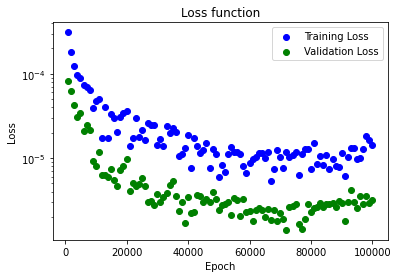

In [13]:
order=jnp.arange(800)
for i in range(epochs):
    train_loss,params=epoch_step(x_train,y_train,params,opt_state,order,a)
    if i % 1000 == 999:
        train_loss=train_loss/25
        validate_loss=mse_loss(params,x_validate,y_validate,a)
        print((i+1),validate_loss)
        plt.scatter((i+1),train_loss,c='b')
        plt.scatter((i+1),validate_loss,c='g')
print("Training ended")
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
checkpoints.save_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks",target=state,step=0,overwrite=True)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function")
plt.legend(["Training Loss","Validation Loss"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/loss.png")

[[0.01189434 0.01209948 0.01230919 ... 0.977854   0.99047756 1.0034704 ]
 [0.01274525 0.01296399 0.0131876  ... 0.9816124  0.992694   1.0031387 ]
 [0.01399273 0.01423346 0.01447964 ... 0.9837818  0.9920102  1.0019746 ]
 ...
 [0.01435676 0.01459589 0.0148405  ... 0.9835972  0.9919462  1.00064   ]
 [0.01582772 0.0160938  0.0163659  ... 0.9874064  0.9937703  1.0040365 ]
 [0.01211193 0.01232226 0.0125373  ... 0.97967213 0.9915512  1.0031873 ]]


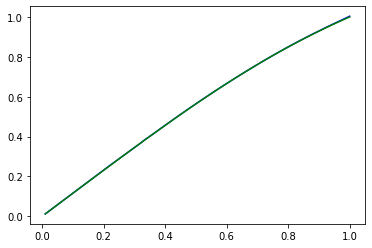

Max error = 0.9272218 %


In [14]:
x_test=jnp.stack((input_data[900:1000,0],input_data[900:1000,2]),axis=1)
y_test=raw_input_result[900:1000,:]
y_pred=jnp.exp(eval_func(params,x_test,a))
print(y_pred)
plt.plot(a,y_pred[0,:],c='b')
plt.plot(a,y_test[0,:],c='g')
plt.show()
error=abs(y_pred/y_test-1)
print("Max error =",jnp.max(error)*100,"%")